# LSTM을 이용한 주가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense, Lambda

- Apple 주식 가격 예측

In [2]:
aapl = yf.download('AAPL', start='2018-01-01', end='2022-12-31', progress=False)
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888073,102223600
2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880943,118071600
2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070839,89738400
2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538441,94640000
2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384155,82271200


<AxesSubplot:xlabel='Date'>

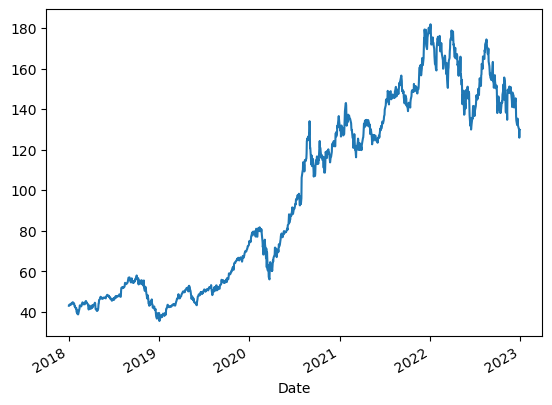

In [3]:
aapl.Close.plot()

LSTM layer로 하려고 하는 것은 지난 window-size 일(즉, t-window에서 t-1까지)의 역사적 가격을 사용하여 시간 t의 가격을 예측하는 것입니다. 정확한 가격이 아닌 추세를 파악하기 위해 노력할 것임을 명심하십시오.

- training dataset 생성

In [4]:
aapl.shape

(1259, 6)

In [5]:
hist = []
target = []
#window = 60
window = 3
close = aapl['Close'].values

for i in range(len(close) - window):
    x = close[i:i+window]
    y = close[i+window]
    hist.append(x)
    target.append(y)

In [6]:
close[:10]

array([43.06499863, 43.05749893, 43.25749969, 43.75      , 43.58750153,
       43.58250046, 43.57249832, 43.81999969, 44.27249908, 44.04750061])

In [7]:
hist[:5]

[array([43.06499863, 43.05749893, 43.25749969]),
 array([43.05749893, 43.25749969, 43.75      ]),
 array([43.25749969, 43.75      , 43.58750153]),
 array([43.75      , 43.58750153, 43.58250046]),
 array([43.58750153, 43.58250046, 43.57249832])]

In [8]:
target[:5]

[43.75,
 43.587501525878906,
 43.58250045776367,
 43.5724983215332,
 43.81999969482422]

확인 방법 

- "hist"의 각 요소는 window개 timestep의 list입니다. 1씩 증가하기 때문에 "hist"의 두 번째 요소의 마지막 항목은 "target"의 첫 번째 요소와 같아야 합니다. 또한 마지막 숫자가 같아야 합니다.

```
print(close[-1])
print(i+length)
print(target[-1])
```

In [9]:
hist[1][-1] == target[0]

True

In [10]:
hist = np.array(hist)
target = np.array(target)
target = target.reshape(-1, 1)
print(hist.shape)
print(target.shape)

(1256, 3)
(1256, 1)


In [11]:
len(hist) - 100

1156

1098일의 데이터로 모델을 학습시키고 다음 100일의 데이터로 테스트하는 방식으로 데이터를 분할합니다.

In [12]:
#train/test split
split = len(hist) - 100
X_train = hist[:split]
X_test = hist[split:]
y_train = target[:split]
y_test = target[split:]

In [13]:
X_train = X_train.reshape(-1, window, 1)
X_tes = X_test.reshape(-1, window, 1)

X_train.shape, X_test.shape

((1156, 3, 1), (100, 3))

- model 생성 및 fitting

In [14]:
model = tf.keras.Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(window, 1), dropout=0.2))
model.add(LSTM(units=32, return_sequences=True, dropout=0.2))
model.add(LSTM(units=16, dropout=0.2))
model.add(Dense(units=1))
model.add(Lambda(lambda x: x * 100))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
37/37 [==============================] - 3s 4ms/step - loss: 5254.3999
Epoch 2/100
37/37 [==============================] - 0s 4ms/step - loss: 1779.6375
Epoch 3/100
37/37 [==============================] - 0s 4ms/step - loss: 383.7669
Epoch 4/100
37/37 [==============================] - 0s 4ms/step - loss: 237.5166
Epoch 5/100
37/37 [==============================] - 0s 4ms/step - loss: 184.5271
Epoch 6/100
37/37 [==============================] - 0s 5ms/step - loss: 204.2559
Epoch 7/100
37/37 [==============================] - 0s 5ms/step - loss: 136.6152
Epoch 8/100
37/37 [==============================] - 0s 5ms/step - loss: 132.6844
Epoch 9/100
37/37 [==============================] - 0s 5ms/step - loss: 96.8458
Epoch 10/100
37/37 [==============================] - 0s 4ms/step - loss: 101.0569
Epoch 11/100
37/37 [==============================] - 0s 4ms/step - loss: 109.3255
Epoch 12/100
37/37 [==============================] - 0s 4ms/step - loss: 104.0627
Epoch 13/100

37/37 [==============================] - 0s 5ms/step - loss: 40.1893


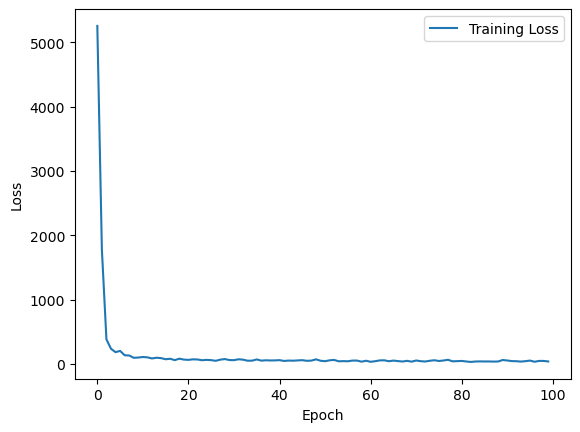

In [17]:
plt.plot(history.history['loss'])
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

앞으로 100일 동안의 주가 추이를 예측해 보도록 하겠습니다. 우리의 목표는 실제 가격이 아니라 추세를 예측하는 것임을 기억하십시오.

4/4 [==============================] - 1s 2ms/step


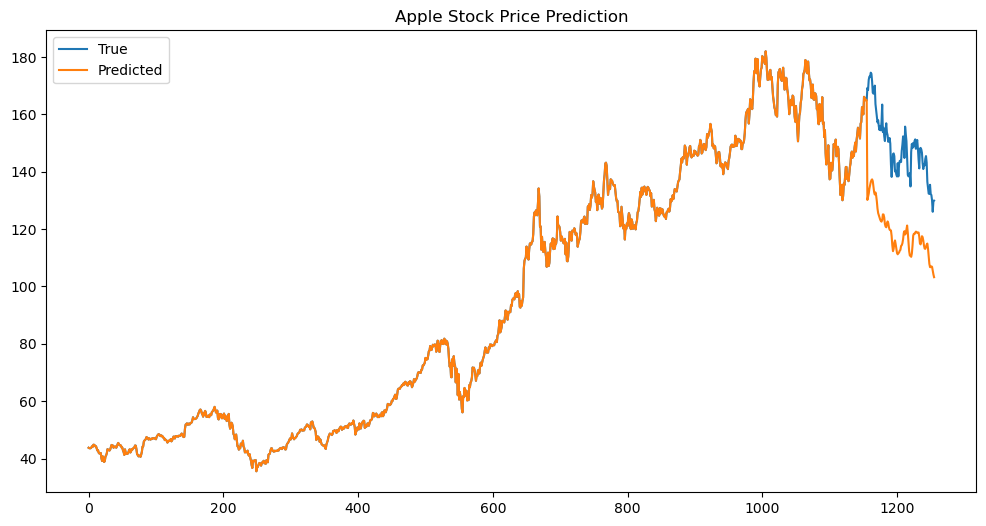

In [18]:
pred = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(np.concatenate((y_train, y_test)), label='True')
plt.plot(np.concatenate((y_train, pred)), label='Predicted')
plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()

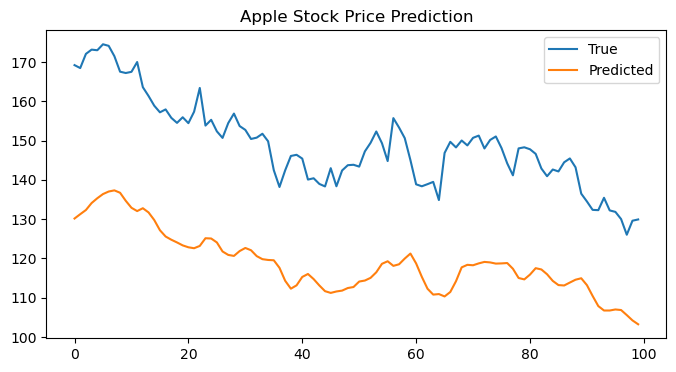

In [19]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label='True')
plt.plot( pred, label='Predicted')
plt.title('Apple Stock Price Prediction')
plt.legend()
plt.show()

## 다양한 window_size tuning 을 하여 보다 정확한 예측 시도